In [1]:
%cd ..

/Users/nattkorat/Workspace/outbreak_event_extraction


In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import evaluation, semantic_similarity

In [3]:
data_path = {
    'gold': 'data/speedpp_test_100.json',
    'pred': 'outputs/gemini2_5__speedpp_100_samples_few_shot.jsonl',
}

In [4]:
for name, path in data_path.items():
    with open(path, 'r') as f:
        if name == 'gold':
            data = json.load(f)
        else:
            data = [json.loads(line) for line in f]

    if name == 'gold':
        gold_data = data
    else:
        pred_data = data

In [5]:
gold_data[0]

{'id': '1cdd443c-3092-4018-8da7-74f10d98a752',
 'text': 'My COVID19 antibodies test came back positive . Crazy . Ive had no symptoms . Please get tested if possible . The more data we have on this the better .',
 'events': {'Infect': [{'trigger': 'positive',
    'arguments': {'disease': 'COVID19', 'infected': 'My'}}]}}

In [6]:
pred_data[:2]

[{'id': '1cdd443c-3092-4018-8da7-74f10d98a752',
  'text': 'My COVID19 antibodies test came back positive . Crazy . Ive had no symptoms . Please get tested if possible . The more data we have on this the better .',
  'events': {'Infect': [{'trigger': 'positive',
     'arguments': {'disease': 'COVID19', 'infected': 'My'}}]}},
 {'id': 'a5c4a89f-820b-4c47-a2b9-ac8889847e87',
  'text': 'The politics of pandemic planning have become increasingly pitched as the ( url ) virus death toll rises . President Trump claims he inherited a broken system from the Obama administration . Critics counter that Trump had three years in office to prepare . ( url )',
  'events': {'Control': [{'trigger': 'planning',
     'arguments': {'disease': 'pandemic',
      'effectiveness': 'increasingly pitched',
      'means': 'planning'}}],
   'Death': [{'trigger': 'death',
     'arguments': {'disease': 'virus', 'trend': 'rises'}}]}}]

In [7]:
def data_transform(data):
    transformed_data = []
    for item in data:
        events = {
            'id': item['id'],
            'events': [],
        }
        for event in item['events']:
            for e in item['events'][event]:
                events['events'].append({
                    'type': event,
                    'trigger': e['trigger'],
                    'arguments': [
                        {
                            'role': k,
                            'text': v
                        } for k, v in e['arguments'].items()
                    ]
                })
        transformed_data.append(events)
    return transformed_data
    

In [8]:
gold_transformed = data_transform(gold_data)
pred_transformed = data_transform(pred_data)

In [9]:
gold_transformed[1]

{'id': 'a5c4a89f-820b-4c47-a2b9-ac8889847e87',
 'events': [{'type': 'Control',
   'trigger': 'planning',
   'arguments': [{'role': 'disease', 'text': 'pandemic'},
    {'role': 'effectiveness', 'text': 'increasingly pitched'},
    {'role': 'means', 'text': 'planning'}]},
  {'type': 'Death',
   'trigger': 'death',
   'arguments': [{'role': 'disease', 'text': 'virus'},
    {'role': 'trend', 'text': 'rises'}]}]}

In [10]:
pred_transformed[1]

{'id': 'a5c4a89f-820b-4c47-a2b9-ac8889847e87',
 'events': [{'type': 'Control',
   'trigger': 'planning',
   'arguments': [{'role': 'disease', 'text': 'pandemic'},
    {'role': 'effectiveness', 'text': 'increasingly pitched'},
    {'role': 'means', 'text': 'planning'}]},
  {'type': 'Death',
   'trigger': 'death',
   'arguments': [{'role': 'disease', 'text': 'virus'},
    {'role': 'trend', 'text': 'rises'}]}]}

In [11]:
def build_event_type_confusion_matrix(gold_data, pred_data):
    matrix = defaultdict(lambda: defaultdict(int))

    for gold_item, pred_item in zip(gold_data, pred_data):
        assert gold_item['id'] == pred_item['id']

        gold_events = gold_item.get("events", [])
        pred_events = pred_item.get("events", [])
        
        if not gold_events and not pred_events:
            matrix['<none>']['<none>'] += 1
            continue

        gold_used = [False] * len(gold_events)
        pred_used = [False] * len(pred_events)

        # Step 1: Exact type match first
        for g_idx, g_event in enumerate(gold_events):
            for p_idx, p_event in enumerate(pred_events):
                if not gold_used[g_idx] and not pred_used[p_idx]:
                    if g_event['type'] == p_event['type']:
                        matrix[g_event['type']][p_event['type']] += 1
                        gold_used[g_idx] = True
                        pred_used[p_idx] = True
                        break

        # Step 2: Try to align mismatched types for remaining ones
        for g_idx, g_event in enumerate(gold_events):
            if gold_used[g_idx]:
                continue
            for p_idx, p_event in enumerate(pred_events):
                if not pred_used[p_idx]:
                    matrix[g_event['type']][p_event['type']] += 1
                    gold_used[g_idx] = True
                    pred_used[p_idx] = True
                    break

        # Step 3: Leftover golds → FN
        for g_idx, g_event in enumerate(gold_events):
            if not gold_used[g_idx]:
                matrix[g_event['type']]['<none>'] += 1

        # Step 4: Leftover preds → FP
        for p_idx, p_event in enumerate(pred_events):
            if not pred_used[p_idx]:
                matrix['<none>'][p_event['type']] += 1

    return matrix

def plot_event_type_confusion(confusion_matrix):
    # Get all unique event types (including '<none>')
    all_types = sorted(set(confusion_matrix.keys()) | 
                       {k for v in confusion_matrix.values() for k in v.keys()})
    
    # Create DataFrame with explicit index and columns
    df = pd.DataFrame(confusion_matrix).fillna(0).astype(int)
    df = df.reindex(index=all_types, columns=all_types, fill_value=0)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, square=True)
    plt.title("Event Type Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Gold")
    plt.tight_layout()
    plt.show()

In [12]:
conf_matrix = build_event_type_confusion_matrix(gold_transformed, pred_transformed)
conf_matrix

defaultdict(<function __main__.build_event_type_confusion_matrix.<locals>.<lambda>()>,
            {'Infect': defaultdict(int,
                         {'Infect': 15,
                          'Prevent': 2,
                          '<none>': 3,
                          'Symptom': 1}),
             'Control': defaultdict(int,
                         {'Control': 17,
                          '<none>': 5,
                          'Spread': 2,
                          'Prevent': 6}),
             'Death': defaultdict(int, {'Death': 8}),
             'Spread': defaultdict(int,
                         {'Spread': 9, 'Infect': 2, '<none>': 2}),
             'Prevent': defaultdict(int,
                         {'Prevent': 10, '<none>': 1, 'Infect': 1}),
             '<none>': defaultdict(int,
                         {'Control': 12,
                          'Prevent': 12,
                          'Infect': 7,
                          'Symptom': 4,
                          '<none>': 12

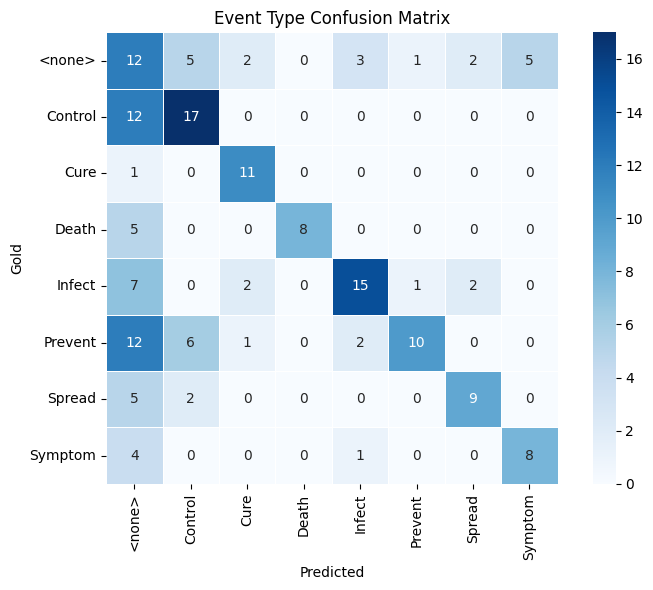

In [13]:
plot_event_type_confusion(conf_matrix)

This is not really a fair technique yet for counting the miss match event since we cannot align the gold and predict events. For instance, in the gold there are `Infect` and `Cure`, but in the Pred has `Prevent`. This means, Infect(FN) = 1, Cure(FN) = 1, Prevent(FP) = 1, but this negative result can't imply to any other event like is `Prevent` vs `Infect` or `Prevent` vs `Cure`?

In [14]:
def evaluate_confusion_matrix(confusion_matrix):
    # Convert to DataFrame with sorted rows and columns
    all_types = sorted(set(confusion_matrix.keys()) | 
                       {k for v in confusion_matrix.values() for k in v})
    df = pd.DataFrame(confusion_matrix).fillna(0).astype(int)
    df = df.reindex(index=all_types, columns=all_types, fill_value=0)

    metrics = {}

    total_tp = total_fp = total_fn = total = correct = 0

    for label in all_types:
        tp = df.at[label, label]  # True Positives
        fp = df[label].sum() - tp  # Predicted as label, but wrong (column sum minus TP)
        fn = df.loc[label].sum() - tp  # Actually label, but predicted wrong (row sum minus TP)

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall    = tp / (tp + fn) if tp + fn > 0 else 0
        f1        = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        metrics[label] = {
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1": round(f1, 4),
            "tp": tp,
            "fp": fp,
            "fn": fn
        }

        total_tp += tp
        total_fp += fp
        total_fn += fn
        correct += tp
        total += df.loc[label].sum()  # total actual instances for this label

    overall_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    overall_recall    = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    overall_f1        = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if overall_precision + overall_recall > 0 else 0
    overall_accuracy  = correct / df.values.sum() if df.values.sum() > 0 else 0

    metrics["overall"] = {
        "precision": round(overall_precision, 4),
        "recall": round(overall_recall, 4),
        "f1": round(overall_f1, 4),
        "accuracy": round(overall_accuracy, 4),
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn
    }

    return metrics

In [15]:
import pandas as pd

def print_confusion_metrics_table(metrics):
    # Convert dictionary to DataFrame
    df = pd.DataFrame(metrics).T

    # Reorder columns if they exist
    cols = ['tp', 'fp', 'fn', 'precision', 'recall', 'f1', 'accuracy']
    df = df[[c for c in cols if c in df.columns]]

    # Format float values for better readability
    float_cols = ['precision', 'recall', 'f1', 'accuracy']
    for col in float_cols:
        if col in df.columns:
            df[col] = df[col].map(lambda x: f"{x:.4f}")

    # Display the DataFrame
    print("\nEvaluation Metrics Table:")
    print(df.to_markdown(tablefmt="grid"))

In [16]:
print_confusion_metrics_table(evaluate_confusion_matrix(conf_matrix))


Evaluation Metrics Table:
+---------+------+------+------+-------------+----------+--------+------------+
|         |   tp |   fp |   fn |   precision |   recall |     f1 |   accuracy |
+=========+======+======+======+=============+==========+========+============+
| <none>  |   12 |   46 |   18 |      0.2069 |   0.4    | 0.2727 |   nan      |
+---------+------+------+------+-------------+----------+--------+------------+
| Control |   17 |   13 |   12 |      0.5667 |   0.5862 | 0.5763 |   nan      |
+---------+------+------+------+-------------+----------+--------+------------+
| Cure    |   11 |    5 |    1 |      0.6875 |   0.9167 | 0.7857 |   nan      |
+---------+------+------+------+-------------+----------+--------+------------+
| Death   |    8 |    0 |    5 |      1      |   0.6154 | 0.7619 |   nan      |
+---------+------+------+------+-------------+----------+--------+------------+
| Infect  |   15 |    6 |   12 |      0.7143 |   0.5556 | 0.625  |   nan      |
+---------+--

In [17]:
trigger_word_gold = defaultdict(list)
trigger_word_pred = defaultdict(list)

for item in gold_transformed:
    for event in item['events']:
        trigger_word_gold[event['type']].append(event['trigger'])

for item in pred_transformed:
    for event in item['events']:
        trigger_word_pred[event['type']].append(event['trigger'])

In [18]:
from fuzzywuzzy import fuzz

def evaluate_trigger_by_type(trigger_word_gold, trigger_word_pred, match_threshold=85):
    results = {}

    all_types = set(trigger_word_gold.keys()) | set(trigger_word_pred.keys())

    for event_type in all_types:
        gold_triggers = trigger_word_gold.get(event_type, [])
        pred_triggers = trigger_word_pred.get(event_type, [])

        matched_gold = set()
        matched_pred = set()

        for i, gt in enumerate(gold_triggers):
            for j, pt in enumerate(pred_triggers):
                if j in matched_pred:
                    continue
                if gt == pt:
                    matched_gold.add(i)
                    matched_pred.add(j)
                    break

        tp = len(matched_gold)
        fp = len(pred_triggers) - tp
        fn = len(gold_triggers) - tp

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        results[event_type] = {
            'TP': tp, 'FP': fp, 'FN': fn,
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1': round(f1, 4),
            'Gold Count': len(gold_triggers),
            'Pred Count': len(pred_triggers)
        }
        
    return results

/opt/homebrew/Caskroom/miniconda/base/envs/ee/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [19]:
def print_trigger_eval_table(results):
    print(f"{'Event Type':<15} {'Gold':<6} {'Pred':<6} {'TP':<4} {'FP':<4} {'FN':<4} {'Prec':<6} {'Rec':<6} {'F1':<6}")
    print("-" * 65)
    for etype, metrics in results.items():
        print(f"{etype:<15} {metrics['Gold Count']:<6} {metrics['Pred Count']:<6} {metrics['TP']:<4} {metrics['FP']:<4} {metrics['FN']:<4} {metrics['Precision']:<6} {metrics['Recall']:<6} {metrics['F1']:<6}")
    
    # overall metrics
    total_tp = sum(metrics['TP'] for metrics in results.values())
    total_fp = sum(metrics['FP'] for metrics in results.values())
    total_fn = sum(metrics['FN'] for metrics in results.values())
    overall_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    overall_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if overall_precision + overall_recall > 0 else 0
    overall_gold_count = sum(metrics['Gold Count'] for metrics in results.values())
    overall_pred_count = sum(metrics['Pred Count'] for metrics in results.values())
    print("-" * 65)
    print(f"{'Overall':<15} {overall_gold_count:<6} {overall_pred_count:<6} {total_tp:<4} {total_fp:<4} {total_fn:<4} {round(overall_precision, 4):<6} {round(overall_recall, 4):<6} {round(overall_f1, 4):<6}")


In [20]:
results = evaluate_trigger_by_type(trigger_word_gold, trigger_word_pred)
print_trigger_eval_table(results)

Event Type      Gold   Pred   TP   FP   FN   Prec   Rec    F1    
-----------------------------------------------------------------
Infect          21     27     15   12   6    0.5556 0.7143 0.625 
Death           8      13     8    5    0    0.6154 1.0    0.7619
Cure            16     12     9    3    7    0.75   0.5625 0.6429
Symptom         13     13     6    7    7    0.4615 0.4615 0.4615
Spread          13     16     9    7    4    0.5625 0.6923 0.6207
Prevent         12     31     7    24   5    0.2258 0.5833 0.3256
Control         30     29     12   17   18   0.4138 0.4    0.4068
-----------------------------------------------------------------
Overall         113    141    66   75   47   0.4681 0.5841 0.5197


In [21]:
gold_args_by_type = defaultdict(list)
pred_args_by_type = defaultdict(list)

for gold_item, pred_item in zip(gold_transformed, pred_transformed):
    assert gold_item['id'] == pred_item['id']
    
    gold_events = gold_item.get('events', [])
    pred_events = pred_item.get('events', [])
    
    for g_event in gold_events:
        gold_args_by_type[g_event['type']].append(g_event['arguments'])
    
    for p_event in pred_events:
        pred_args_by_type[p_event['type']].append(p_event['arguments'])

In [22]:
gold_args_by_type.keys()

dict_keys(['Infect', 'Control', 'Death', 'Spread', 'Prevent', 'Symptom', 'Cure'])

In [23]:
def evaluate_arguments(gold_args_list, pred_args_list):
    role_counts = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})
    
    for g_args, p_args in zip(gold_args_list, pred_args_list):
        gold_roles = set(arg['role'] for arg in g_args)
        pred_roles = set(arg['role'] for arg in p_args)
        
        for role in gold_roles & pred_roles:
            role_counts[role]["tp"] += 1
        for role in gold_roles - pred_roles:
            role_counts[role]["fn"] += 1
        for role in pred_roles - gold_roles:
            role_counts[role]["fp"] += 1
    
    return role_counts

In [33]:
def calculate_prf(role_counts):
    tp = role_counts["tp"]
    fp = role_counts["fp"]
    fn = role_counts["fn"]
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    metrics = {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "tp": tp,
        "fp": fp,
        "fn": fn
    }
    
    return metrics

In [37]:
from tabulate import tabulate

for event_type in gold_args_by_type:
    gold = gold_args_by_type[event_type]
    pred = pred_args_by_type.get(event_type, [])
    role_scores = evaluate_arguments(gold, pred)
    
    results_table = []
    for role, stats in role_scores.items():
        res = calculate_prf(stats)
        results_table.append([
            role,
            stats['tp'],
            stats['fp'],
            stats['fn'],
            res['precision'],
            res['recall'],
            res['f1']
        ])
    
    print(f"\nEvent Type: {event_type}")
    print(tabulate(results_table, headers=["Role", "TP", "FP", "FN", "Precision", "Recall", "F1"], tablefmt="grid"))


Event Type: Infect
+--------------------+------+------+------+-------------+----------+--------+
| Role               |   TP |   FP |   FN |   Precision |   Recall |     F1 |
+====================+======+======+======+=============+==========+========+
| infected           |   13 |    3 |    5 |      0.8125 |   0.7222 | 0.7647 |
+--------------------+------+------+------+-------------+----------+--------+
| disease            |   18 |    2 |    1 |      0.9    |   0.9474 | 0.9231 |
+--------------------+------+------+------+-------------+----------+--------+
| place              |    3 |    4 |    3 |      0.4286 |   0.5    | 0.4615 |
+--------------------+------+------+------+-------------+----------+--------+
| information-source |    1 |    0 |    1 |      1      |   0.5    | 0.6667 |
+--------------------+------+------+------+-------------+----------+--------+
| value              |    0 |    4 |    2 |      0      |   0      | 0      |
+--------------------+------+------+------+-